In [0]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import urllib.request
from progressbar import *
import socket
import os
import shutil
import cv2
import dlib
from PIL import Image
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt

# Reading data

[FaceScrub dataset link](http://vintage.winklerbros.net/facescrub.html "FaceScrub")   

<img align="left" width="580" height="200" src="http://vintage.winklerbros.net/Images/facescrub.jpg">   

In [0]:
base_dir = "/content/drive/My Drive/Colab/Roonyx/Face recognition"

f = open(base_dir + "/faceScrub/facescrub_actors.txt", 'r')
actors = []
for line in f:
    actor_info = line.split('\t')
    actors.append([actor_info[0], actor_info[3]])
actors = np.array(actors)
f.close()

f = open(base_dir + "/faceScrub/facescrub_actresses.txt", 'r')
actresses = []
for line in f:
    actresses_info = line.split('\t')
    actresses.append([actresses_info[0], actresses_info[3]])
actresses = np.array(actresses)
f.close()

# Example of data

In [0]:
pd.DataFrame(data=actors[1:11], columns=actors[0])

,name,url
0,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
1,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...
2,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
3,Aaron Eckhart,http://25.media.tumblr.com/nJ2vga5sae9o2ks4Flt...
4,Aaron Eckhart,http://upload.wikimedia.org/wikipedia/commons/...
5,Aaron Eckhart,http://media.zenfs.com/en_us/Movies/PhotoG/2nd...
6,Aaron Eckhart,http://img2.timeinc.net/people/i/2008/news/080...
7,Aaron Eckhart,http://latimesblogs.latimes.com/photos/uncateg...
8,Aaron Eckhart,http://collider.com/wp-content/uploads/Aaron-E...
9,Aaron Eckhart,http://movies.dosthana.com/sites/default/files...


# Dataset info

In [13]:
names_actors = unique_labels(actors[1:,0])
names_actresses = unique_labels(actresses[1:,0])

print("Num images: ", len(actors) + len(actresses) - 2)
print("Num images with actors: ", len(actors) - 1)
print("Num images with actresses: ", len(actresses) - 1)
print("Num actors:", len(names_actors))
print("Num actresses:", len(names_actresses))

Num images:  106863
Num images with actors:  55306
Num images with actresses:  51557
Num actors: 265
Num actresses: 265


# Download images

In [0]:
folder_for_actors = base_dir + "/faceScrub/actors_images"
!mkdir '$folder_for_actors'
folder_for_actresses = base_dir + "/faceScrub/actresses_images"
!mkdir '$folder_for_actresses'

In [0]:
def download(index_start, index_stop, sex='male'):

  def url_is_alive(url):
    try:
        urllib.request.urlopen(url)
        return True
    except Exception:
        return False

  if sex == "male":
    peoples = actors
  elif sex == "female":
    peoples = actresses
  else: 
    return None

  pbar = ProgressBar(maxval=index_stop-index_start)
  pbar.start()
  socket.setdefaulttimeout(5)

  # Download images
  progress = 0
  for image_id in range(index_start,index_stop,1):
    href = peoples[image_id,1]
    if(url_is_alive(href)):
      try:
        if sex == 'female':
          urllib.request.urlretrieve(href,folder_for_actresses+"/{}.jpg".format(image_id+len(actors)-1))
        else:  urllib.request.urlretrieve(href, folder_for_actors+"/{}.jpg".format(image_id))
      except Exception: pass
    pbar.update(progress)
    progress+=1
        
  pbar.finish()

In [0]:
download(1,10000,"male")

100% (9999 of 9999) |####################| Elapsed Time: 3:57:58 Time:  3:57:58


In [0]:
download(10000,20000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:42:45 Time:  1:42:45


In [0]:
download(20000,30000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:47:03 Time:  1:47:03


In [0]:
download(30000,40000,"male")

100% (10000 of 10000) |##################| Elapsed Time: 1:43:21 Time:  1:43:21


In [0]:
download(40000,55306,"male")

100% (15306 of 15306) |##################| Elapsed Time: 4:41:44 Time:  4:41:44


In [0]:
download(1,10000,"female")

100% (9999 of 9999) |####################| Elapsed Time: 2:13:33 Time:  2:13:33


In [0]:
download(10000,20000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:58:13 Time:  1:58:13


In [0]:
download(20000,30000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 1:38:27 Time:  1:38:27


In [0]:
download(30000,40000,"female")

100% (10000 of 10000) |##################| Elapsed Time: 3:57:18 Time:  3:57:18


In [0]:
download(40000,51557,"female")

100% (11557 of 11557) |##################| Elapsed Time: 2:22:22 Time:  2:22:22


In [0]:
print("Num downloaded images:", len(os.listdir(folder_for_actors))+len(os.listdir(folder_for_actresses)))

Num downloaded images: 57198


# Searching broken images

In [0]:
folder_for_bad_actors = base_dir + "/faceScrub/actors_bad_images"
!mkdir '$folder_for_bad_actors'
folder_for_bad_actresses = base_dir + "/faceScrub/actresses_bad_images"
!mkdir '$folder_for_bad_actresses'

In [10]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actors+"/{}.jpg".format(actors_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actors+"/{}.jpg".format(actors_files_names[i]),
                  folder_for_bad_actors+"/{}.jpg".format(actors_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (29804 of 29804) |##################| Elapsed Time: 2:07:42 Time:  2:07:42


In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  try:
    image = cv2.imread(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  except Exception:
      shutil.move(folder_for_actresses+"/{}.jpg".format(actresses_files_names[i]),
                  folder_for_bad_actresses+"/{}.jpg".format(actresses_files_names[i]))
  pbar.update(progress)
  progress+=1   
pbar.finish()

100% (27394 of 27394) |##################| Elapsed Time: 2:59:52 Time:  2:59:52


In [25]:
print("Num broken images: ", len(os.listdir(folder_for_bad_actors)) + len(os.listdir(folder_for_bad_actresses)))
print("Num good images: ", len(os.listdir(folder_for_actors)) + len(os.listdir(folder_for_actresses)))

Num broken images:  7486
Num good images:  49712


# Crope faces on images

In [0]:
folder_for_croped_images = base_dir + "/faceScrub/croped_images"
# !mkdir '$folder_for_croped_images'
folder_for_croped_actors = folder_for_croped_images + "/croped_actors"
# !mkdir '$folder_for_croped_actors'
folder_for_croped_actresses = folder_for_croped_images + "/croped_actresses"
# !mkdir '$folder_for_croped_actresses'

In [0]:
def find_face_rectangle(image_path):
  image = io.imread(image_path)
  detector = dlib.get_frontal_face_detector()
  face_rects = detector(image, 1)
  left, right, bottom, top = 0,0,0,0
  for i, d in enumerate(face_rects):
    if i==0:
      left = d.left()
      top = d.top()
      right = d.right()
      bottom = d.bottom()
  if left==0 and top==0 and right==0 and bottom==0:
    return None
  else: 
    return left, top, right, bottom

In [0]:
def crop_and_save(image_path, left, top, right, bottom, sex):
  img = Image.open(image_path)
  croped_image = img.crop((left,top,right,bottom))
  croped_image = croped_image.resize((128, 128)) 
  if sex == "male":
    croped_image.save(folder_for_croped_actors + "/" + image_path.split("/")[-1])
  elif sex == "female":
    croped_image.save(folder_for_croped_actresses + "/" + image_path.split("/")[-1])

In [0]:
actors_files_names = os.listdir(folder_for_actors)

pbar = ProgressBar(maxval=len(actors_files_names))
pbar.start()
progress = 0
for i in range(0,len(actors_files_names),1):
  image_path = folder_for_actors + "/" + actors_files_names[i]
  croped_image_path = folder_for_croped_actors + "/" + actors_files_names[i]
  if(find_face_rectangle(image_path)) !=None:
    left, top, right, bottom = find_face_rectangle(image_path)
    crop_and_save(image_path, left, top, right, bottom, "male")
  pbar.update(progress)
  progress+=1   
pbar.finish()

  0% (84 of 26309) |                     | Elapsed Time: 0:03:22 ETA:   7:33:02

In [0]:
actresses_files_names = os.listdir(folder_for_actresses)

pbar = ProgressBar(maxval=len(actresses_files_names))
pbar.start()
progress = 0
for i in range(0,len(actresses_files_names),1):
  image_path = folder_for_actresses + "/" + actresses_files_names[i]
  croped_image_path = folder_for_croped_actresses + "/" + actresses_files_names[i]
  if(find_face_rectangle(image_path)) !=None:
    left, top, right, bottom = find_face_rectangle(image_path)
    crop_and_save(image_path, left, top, right, bottom, "female")
  pbar.update(progress)
  progress+=1   
pbar.finish()

# Save metadata

In [0]:
folder_for_metadata = base_dir + "/faceScrub/metadata"
!mkdir '$folder_for_metadata'

In [0]:
actors_files_names = os.listdir(folder_for_croped_actors)
actresses_files_names = os.listdir(folder_for_croped_actresses)
names_all = np.append(names_actors, names_actresses)
names_all = np.array(names_all)
metadata = []

for i in range(0,len(actors_files_names),1):
  index_dot = actors_files_names[i].find('.')
  actors_files_names[i] = int(actors_files_names[i][:index_dot])
  name_id = np.where(names_all == actors[actors_files_names[i]][0])[0][0]
  metadata.append([actors_files_names[i], name_id, actors[actors_files_names[i]][0], "male"])

for i in range(0,len(actresses_files_names),1):
  index_dot = actresses_files_names[i].find('.')
  actresses_files_names[i] = int(actresses_files_names[i][:index_dot])
  id_in_actresses = actresses_files_names[i]-(len(actors)-1)
  name_id = np.where(names_all == actresses[id_in_actresses][0])[0][0]
  metadata.append([actresses_files_names[i], name_id,
                   actresses[actresses_files_names[i]-(len(actors)-1)][0], "female"])

metadata = np.array(metadata)
np.savez(folder_for_metadata +'/metadata', metadata=metadata)

np.savez(folder_for_metadata + '/names_all', names_all=names_all)

In [17]:
pd.DataFrame(data=metadata, columns=["image_id", "person_id", "name", "sex"])

,image_id,person_id,name,sex
0,53473,258,Steve Carell,male
1,53475,258,Steve Carell,male
2,53476,258,Steve Carell,male
3,53478,258,Steve Carell,male
4,53480,258,Steve Carell,male
...,...,...,...,...
49707,65454,517,Tracey E. Bregman,female
49708,65459,517,Tracey E. Bregman,female
49709,65461,517,Tracey E. Bregman,female
49710,65463,517,Tracey E. Bregman,female


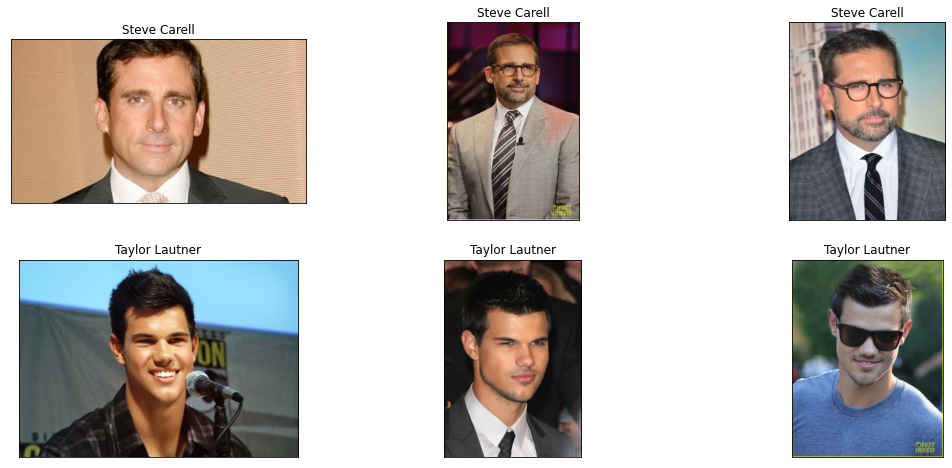

In [20]:
images, labels = [],[]
for i in range(1,4,1):
  j = metadata[i][0]
  image = cv2.imread(folder_for_actors+"/{}.jpg".format(j))
  images.append(image)
  labels.append(metadata[i][2])

for i in range(200,203,1):
  j = metadata[i][0]
  image = cv2.imread(folder_for_actors+"/{}.jpg".format(j))
  images.append(image)
  labels.append(metadata[i][2])

fix,axes = plt.subplots(2,3, figsize=(18,8), subplot_kw={'xticks':(),'yticks':()})
for img, label, ax in zip(images, labels, axes.ravel()):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img, cmap=plt.cm.binary)
    ax.set_title(label)